In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import re
from itertools import chain
from collections import Counter

import numpy as np
import scipy.stats
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.grid_search import RandomizedSearchCV
from sklearn_crfsuite.metrics import flat_classification_report, sequence_accuracy_score
from sklearn_crfsuite import scorers
from sklearn_crfsuite import CRF

from formasaurus.annotation import get_annotation_folds
from formasaurus.storage import Storage
from formasaurus import formtype_model, fieldtype_model

In [3]:
storage = Storage('../formasaurus/data/')
index = storage.get_index()
field_schema = storage.get_field_schema()
form_schema = storage.get_form_schema()

Many field types have only a few examples in annotation data, so here we're considering only some of the field types and use more coarse grained classes. Simplification rules are defined in config.json file.

For easier debugging long class names are used by default.

In [4]:
_ann_iter = storage.iter_annotations(
    index=index, 
    simplify_form_types=True,
    simplify_field_types=True
)

annotations_all = list(a for a in _ann_iter if True)
annotations_complete = [a for a in annotations_all if a.fields_annotated]
len(annotations_complete), len(annotations_all)

(1192, 1244)

The model is two-stage:

1. First, we train Formasaurus form type detector.
2. Second, we use form type detector results to improve quality of field type detection.

We have form types available directly in training data, but in reality form type detecor will make mistakes. It is better for field type detector to account for this and not rely on form types blindly. So it should be trained on input where form type detection quality is roughly the same it'll be in real life. 

To get 'realistic' form type labels we split data into 10 folds, and then for each fold we predict its labels using form type detector trained on the rest 9 folds.

In [5]:
%%time
form_types_realistic = formtype_model.get_realistic_form_labels(annotations_complete, n_folds=10)

CPU times: user 12.6 s, sys: 61.5 ms, total: 12.7 s
Wall time: 12.7 s


In [6]:
form_types_realistic[100]

'login'

Check quality - it should be around 0.9:

In [7]:
form_types_correct = np.asarray([a.type_full for a in annotations_complete])
accuracy_score(form_types_correct, form_types_realistic)

0.8901006711409396

Prepare training/testing data for field type detection. We use 1/4 (25%) of data for testing.

In [8]:
%%time
def get_annotation_train_test_indices(annotations, n_folds=4):
    """
    Split annotations into train and test parts, return train and test indices.
    The size of test part is approximately ``len(annotations)/n_folds``.
    it is guaranteed forms from the same website can't be both
    in train and test parts.
    """
    for idx_train, idx_test in get_annotation_folds(annotations, n_folds):
        break
    return idx_train, idx_test

def select_by_index(arr, index):
    """
    Like numpy indexing, but for lists. This is for cases
    conversion to numpy array is problematic.

    >>> select_by_index(['a', 'b', 'c', 'd'], [0, 3])
    ['a', 'd']
    """
    return [arr[i] for i in index]

idx_train, idx_test = get_annotation_train_test_indices(annotations_complete, 4)

annotations_train = select_by_index(annotations_complete, idx_train)
annotations_test = select_by_index(annotations_complete, idx_test)

# form_types_train = form_types_realistic[idx_train]
form_types_train = form_types_correct[idx_train]
form_types_test = form_types_realistic[idx_test]

X_train, y_train = fieldtype_model.get_Xy(annotations_train, form_types_train, full_type_names=True)
X_test, y_test = fieldtype_model.get_Xy(annotations_test, form_types_test, full_type_names=True)
X, y = X_train + X_test, y_train + y_test
print(len(X_train), len(X_test))

894 298
CPU times: user 1.72 s, sys: 18.3 ms, total: 1.74 s
Wall time: 1.75 s


In [9]:
#[(idx, yseq) for idx, yseq in enumerate(y_train) if 'GENDER' in yseq]

In [10]:
# X_train[10]

Find regularization parameters for field type detector using randomized search. 
We're optimizing for weighted average of F1 metric. Only training data is used; 5-fold cross-validation is performed at each iteration.

Note that this may take quite a lot of CPU time and RAM.

In [11]:
%%time
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
#     'max_iterations': [25, 30, 35, 100]
#     'min_freq': [None, 2],
}

crf = CRF(all_possible_transitions=True, max_iterations=100)
rs = RandomizedSearchCV(crf, params_space, 
    cv=get_annotation_folds(annotations_train, 5), 
    verbose=1, 
    n_jobs=-1, 
    n_iter=50,
    iid=False, 
    scoring=scorers.sequence_accuracy #fieldtype_model.scorer
)
rs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  5.5min finished


CPU times: user 52.1 s, sys: 2.03 s, total: 54.1 s
Wall time: 5min 35s


In [12]:
crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best score:', rs.best_score_)
print("model size: {:0.2f}M".format(crf.size_ / 1000000))

best params: {'c1': 0.12763081501711115, 'c2': 0.022130453058798433}
best score: 0.7607055426526896
model size: 0.59M


In [13]:
rs.best_params_, crf.score(X_test, y_test)

({'c1': 0.12763081501711115, 'c2': 0.022130453058798433}, 0.81810490693739424)

Dark blue => 0.733, dark red => 0.761


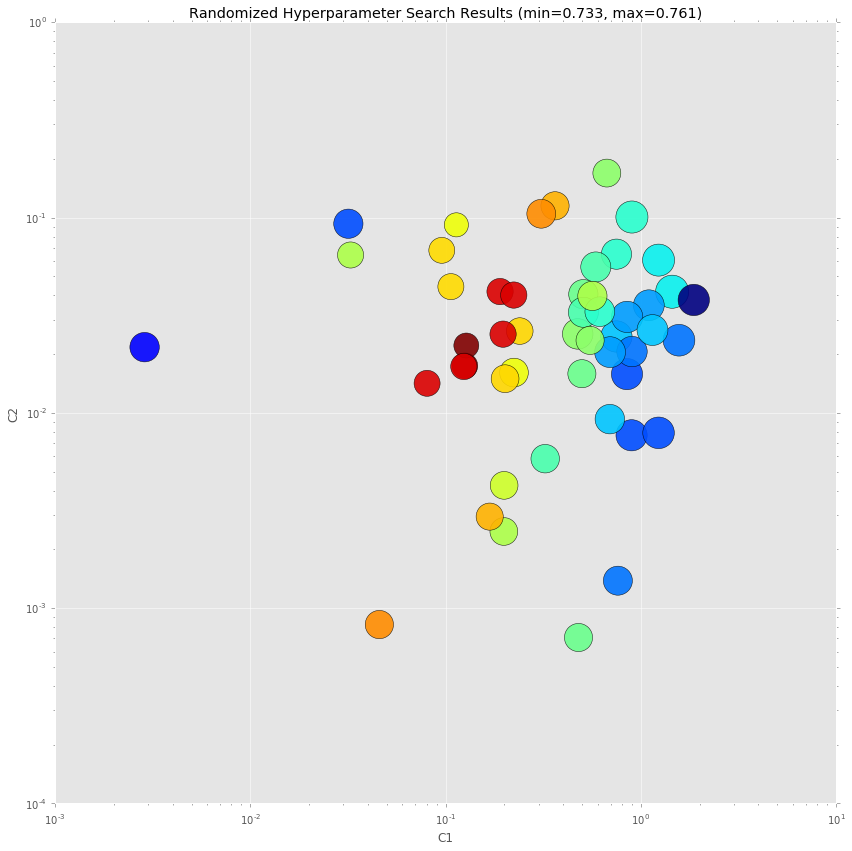

In [14]:
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]
_s = [200000*s.cv_validation_scores.std()**2 for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(14, 14)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=_s, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.3}, dark red => {:0.3}".format(min(_c), max(_c)))

In [15]:
# %%time
crf = rs.best_estimator_
# crf = CRF(c1=0.358, c2=0.161, verbose=False, max_iterations=200)
# crf = CRF(c1=0.217, c2=0.05, verbose=False, max_iterations=30)
# crf = CRF(c1=0.643, c2=0.198, verbose=False, max_iterations=200)
# crf = CRF(c1=0.358, c2=0.161, verbose=False, max_iterations=200)
crf.fit(X_train, y_train)
crf.score(X_test, y_test)

0.81810490693739424

In [16]:
#crf.fit(X, y)

In [17]:
y_pred = crf.predict(X_test)
print(flat_classification_report(
    y_test, y_pred, digits=3, labels=crf.classes_, target_names=crf.classes_
))

                              precision    recall  f1-score   support

                search query      0.900     0.964     0.931        84
                       email      0.921     0.952     0.936       147
                    password      1.000     0.988     0.994        83
            product quantity      1.000     0.643     0.783        14
               submit button      1.000     0.987     0.993        77
                    username      0.717     0.884     0.792        43
       password confirmation      1.000     1.000     1.000        27
 receive emails confirmation      0.625     0.192     0.294        26
                  first name      0.947     0.783     0.857        23
                   last name      1.000     0.857     0.923        21
           organization name      1.000     0.667     0.800         3
                     address      0.750     0.450     0.563        20
                        city      0.875     0.583     0.700        12
                   

/Users/kmike/envs/py3-splash/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kmike/envs/py3-splash/lib/python3.4/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [18]:
# import pandas as pd
# pd.options.display.max_rows = 50
# pd.options.display.max_columns = 50
# labels_short = [field_schema.types[name] for name in labels]

# pd.DataFrame(confusion_matrix(y_true_flat, y_pred_flat, labels), index=labels_short, columns=labels_short)

In [19]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-30s -> %-30s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(100))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-10:])

Top likely transitions:
security question              -> answer to security question    4.970772
first name                     -> last name                      4.608590
month                          -> day                            4.525933
password                       -> password confirmation          4.516606
username                       -> password                       3.314564
comment title or subject       -> comment text                   3.253280
month                          -> year                           3.073022
sorting option                 -> sorting option                 3.026889
comment title or subject       -> comment title or subject       2.949091
email                          -> email confirmation             2.749066
other number                   -> other number                   2.732831
phone                          -> fax                            2.579593
postal code                    -> city                           2.517252
address       

In [20]:
def _filtered_state_features(state_features, query, k=1):
    return Counter({
        (attr, label): weight
        for ((attr, label), weight) in state_features.items()
        if (query in attr or query in label) and k*weight >= 0
    })


def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-30s %s" % (weight, label, attr))    
        

def print_top_positive(crf, N, query=''):
    print("\nTop positive:")
    cnt = _filtered_state_features(crf.state_features_, query, 1)
    print_state_features(cnt.most_common(N))
    

def print_top_negative(crf, N, query=''):
    print("\nTop negative:")
    cnt = _filtered_state_features(crf.state_features_, query, -1)
    print_state_features(cnt.most_common()[-N:])
    

def print_top(crf, N, query=''):
    cnt = _filtered_state_features(crf.state_features_, query, 0)
    print_state_features(cnt.most_common(N))
    

print_top(crf, 150, 'form-type')

# print("\nTop negative:")
# print_top_negative(info, 30, 'input-type')

5.503887 search category / refinement   form-type:search
5.191162 search query                   form-type:search
3.687156 product quantity               form-type:order/add to cart
3.480852 remember me checkbox           form-type:login
2.859949 sorting option                 form-type:search
2.809606 comment text                   form-type:contact/comment
2.278853 full name                      form-type:contact/comment
2.264468 comment title or subject       form-type:contact/comment
1.915475 TOS confirmation               form-type:other
1.909192 email                          form-type:join mailing list
1.700867 other number                   form-type:search
1.698757 honeypot                       form-type:contact/comment
1.599296 username                       form-type:password/login recovery
1.507415 other                          form-type:other
1.486112 receive emails confirmation    form-type:registration
1.412938 about me text                  form-type:registration
1.34